# Hierarchical clustering


The objective of this lab is to test hierarchical clustering on both synthetic and real data and to select the $k$ best clusterings from the dendrogram by $k$-means clustering.

We use graph data, since real graphs have a natural **multi-scale** structure.

You will find below Python code for:
* loading and displaying a graph (you will need the [networkx](https://networkx.github.io) package)
* embedding the graph in the Euclidean space to get vector data
* clustering these vector data by the Ward method (hierarchical clustering)
* extract clusterings from the resulting **dendrogram**

## To do

1. Apply weighted $k$-means to the heights of the dendrogram (1D data = distances from the bottom of the tree) to select the $k$ best clusterings. The weight of a given height of the dendrogram must correspond to the number of samples in the corresponding cluster (branching point of the dendrogram).
2. Display the 2 best clusterings of [Open Flights](http://openflights.org) and other datasets of your choice.

## Import packages

In [1]:
import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.cluster.hierarchy as sch

In [2]:
from sklearn.metrics import adjusted_rand_score as ari

In [3]:
import networkx as nx

In [4]:
import warnings
warnings.filterwarnings("ignore")

## A simple dataset

We first apply hierarchical clustering on a simple dataset: the [Karate Club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

In [47]:
graph = nx.karate_club_graph()

In [62]:
print(graph)

Zachary's Karate Club


In [48]:
print(nx.info(graph))

Name: Zachary's Karate Club
Type: Graph
Number of nodes: 34
Number of edges: 78
Average degree:   4.5882


In [49]:
# Get labels (for more information, see the description of the dataset)
clubs = nx.get_node_attributes(graph, 'club')
club_names = list(set(clubs.values()))
club_indices = {name: i for i,name in enumerate(club_names)}
labels = np.array([club_indices[graph.node[i]['club']] for i in graph.nodes])

In [50]:
COLORS = np.array(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'grey', 'orange'])

In [51]:
def display_graph(graph,labels = None,pos = None,figsize = (5,5),node_size = 200,alpha = 0.1):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if pos is None:
        pos = nx.spring_layout(graph)
    nodes = nx.draw_networkx_nodes(graph,pos,node_size = node_size,node_color='w')
    nodes.set_edgecolor('k')
    nx.draw_networkx_edges(graph,pos,alpha=alpha)
    if labels is not None:
        nodes = nx.draw_networkx_nodes(graph,pos,node_size = node_size,node_color = COLORS[labels % len(COLORS)])
        nodes.set_edgecolor('k')
    plt.show()    

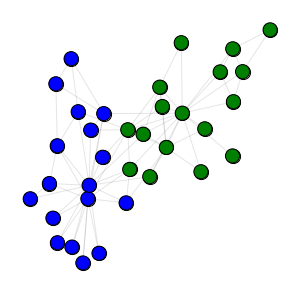

In [52]:
pos = nx.spring_layout(graph)
display_graph(graph, labels, pos)

## Spectral embedding

In [53]:
adjacency = nx.to_scipy_sparse_matrix(graph)

In [54]:
def spectral_embedding(adjacency, k):
    '''Spectral embedding

        Parameters
        ----------
        adjacency: sparse symmetric matrix 
            Adjacency matrix of a graph

        k: integer
            Dimension of the embedding
            
        Returns
        -------
        embedding: array of shape(dim,k)
            Spectral embedding on the unit sphere
    '''
    
    # Laplacian matrix
    n = adjacency.shape[0] 
    degrees = sparse.csr_matrix.dot(adjacency, np.ones(n))
    normalization = sparse.diags(1. / np.sqrt(degrees), format = 'csr')
    laplacian = sparse.identity(n) - normalization.dot(adjacency.dot(normalization))

    # Spectral embedding
    eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, min(k + 1,n - 1), which='SM')
    embedding = np.array(normalization.dot(eigenvectors[:,1:]))    
    embedding = (embedding.T / np.linalg.norm(embedding, axis = 1)).T
    
    return embedding

In [55]:
samples = spectral_embedding(adjacency,2)

## Hierarchical clustering

In [56]:
D = sch.linkage(samples, method =  'ward')

In [63]:
print(D)

[[1.50000000e+01 2.00000000e+01 0.00000000e+00 2.00000000e+00]
 [1.80000000e+01 2.20000000e+01 1.11022302e-16 2.00000000e+00]
 [3.40000000e+01 3.50000000e+01 4.00296604e-16 4.00000000e+00]
 [4.00000000e+00 1.00000000e+01 4.57756680e-16 2.00000000e+00]
 [1.40000000e+01 3.60000000e+01 6.14145032e-16 5.00000000e+00]
 [1.70000000e+01 2.10000000e+01 6.28036983e-16 2.00000000e+00]
 [5.00000000e+00 6.00000000e+00 6.47365705e-16 2.00000000e+00]
 [3.00000000e+00 7.00000000e+00 1.64705026e-03 2.00000000e+00]
 [1.20000000e+01 3.90000000e+01 3.59142837e-03 3.00000000e+00]
 [9.00000000e+00 3.00000000e+01 1.73150485e-02 2.00000000e+00]
 [2.60000000e+01 2.90000000e+01 2.41256080e-02 2.00000000e+00]
 [2.40000000e+01 2.50000000e+01 2.46944730e-02 2.00000000e+00]
 [1.00000000e+00 1.90000000e+01 2.84793449e-02 2.00000000e+00]
 [2.30000000e+01 3.10000000e+01 3.72288475e-02 2.00000000e+00]
 [3.20000000e+01 3.80000000e+01 3.86411944e-02 6.00000000e+00]
 [8.00000000e+00 4.30000000e+01 7.42825617e-02 3.000000

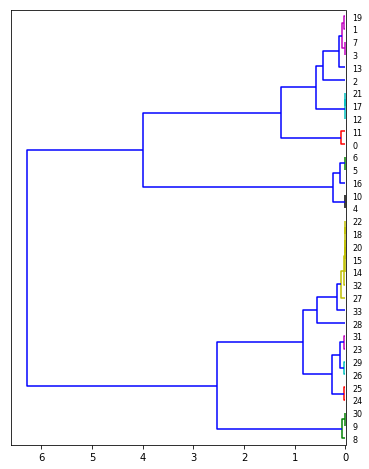

In [69]:
plt.figure(figsize = (6,8))
sch.dendrogram(D,orientation = 'left',color_threshold = 0.1,leaf_font_size = 8)
plt.show()

In [58]:
def select_clustering(D, k):
    '''Clustering with k clusters'''
    n = np.shape(D)[0] + 1
    clusters = {i:[i] for i in range(n)}
    for t in range(n - k):
        clusters[n + t] = clusters.pop(int(D[t][0])) + clusters.pop(int(D[t][1]))
    cluster_list = sorted(clusters.values(), key = len, reverse = True)
    labels = np.zeros(n, dtype = int)
    for j,index in enumerate(cluster_list):
        labels[np.array(index)] = j
    return labels

In [76]:
labels_pred = select_clustering(D, 6)

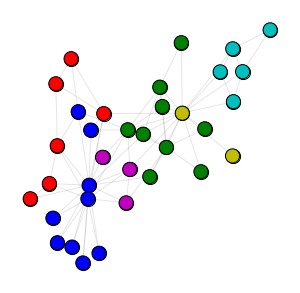

In [77]:
display_graph(graph, labels_pred, pos)

In [78]:
ari(labels, labels_pred)

0.3637765781645918

## Selection of best clusterings by weighted $k$-means

It seems that the two best clusterings of the Karate club are for cuts of the dendrogram around 2 and 5:

In [79]:
number_clusterings = 2
cut_positions = [2,5]

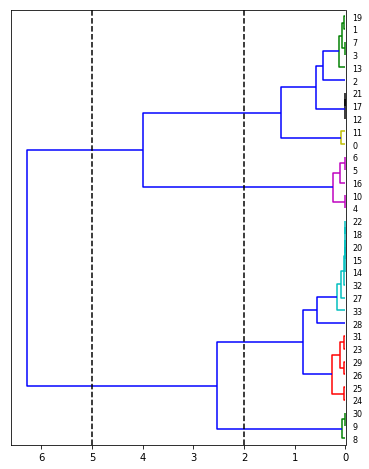

In [81]:
plt.figure(figsize = (6,8))
sch.dendrogram(D,orientation = 'left',color_threshold = 0.3,leaf_font_size = 8)
for j in range(number_clusterings):
    plt.axvline(cut_positions[j],ls = '--',color = 'k')
plt.show()

The objective is to get these cut positions by weighted $k$-means on the heights of the dendrogram:

In [82]:
class KMeans:
    '''k-means algorithm with sample weights
    
    Parameters
    ----------
    n_clusters: int, default: 8
        Number of clusters.
    
    n_init : int, default: 10
        Number of instances of k-means, each with different initial centers. 
        The output is that of the best instance (in terms of inertia).
    
    n_iter: int, default: 300
        Number of iterations for each instance of k-means.
        
    algorithm: "random" or "++", default:"++"
        Algorithm for initializing the centers; "++" corresponds to k-means++.
    
    seed: int, default: None
        Seed for the random generation of initial centers.
        
    verbose : boolean, optional
        Verbose mode.
    
    Attributes
    ----------
    labels_: array, shape(n_samples,)
        Label of each sample.
        
    centers_ : array, shape(n_clusters, n_features)
        Cluster centers.
        
    inertias_: array, shape(n_clusters,)
        Cluster inertias (sum of square distances).
    '''

    def __init__(self, n_clusters=8, n_init=10, n_iter=300, algorithm='++', seed=None, verbose = False):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.n_iter = n_iter
        self.algorithm = algorithm
        self.seed = seed
        self.verbose = verbose
        self.labels_ = None
        self.centers_ = None
        self.inertias_ = None
       
    def fit(self, X, weights):
        '''Cluster data X using k-means
    
        Parameters
        ----------
        X: array, shape(n_samples,n_features)
            Data samples to cluster.
            
        weights: array, shape(n_samples,)
            Sample weights.
        '''        
        
        def init_centers(self, X, weights):
            p = weights / np.sum(weights)
            if self.algorithm == 'random':
                # random centers 
                samples = np.random.choice(X.shape[0], size = self.n_clusters, p = p)
                centers = X[samples]
            else:
                # k-means++
                centers = []
                centers.append(X[np.random.randint(X.shape[0])])
                distance = np.full(X.shape[0], np.inf)
                for j in range(1,self.n_clusters):
                    distance = np.minimum(np.linalg.norm(X - centers[-1], axis=1), distance)
                    p = np.square(distance) / np.sum(np.square(distance))
                    sample = np.random.choice(X.shape[0], p = p)
                    centers.append(X[sample])
            return np.array(centers)
        
        def compute_centers(self, X, weights, labels):
            centers = []
            for j in range(self.n_clusters):
                index = np.where(labels == j)[0]
                if len(index):
                    centers.append(np.average(X[index],axis = 0,weights = weights[index]))
                else:
                    # reinit center in case of empty cluster
                    centers.append(X[np.random.choice(X.shape[0])])
            return np.array(centers)

        def compute_distances(self, X, centers):
            distances = []
            for j in range(self.n_clusters):
                distances.append(np.linalg.norm(X - centers[j], axis=1))
            return np.array(distances)
            
        def compute_inertias(self, X, weights, centers, clusters):
            inertias = []
            for j in range(self.n_clusters):
                index = np.where(clusters == j)[0]
                inertias.append(np.sum(np.square(np.linalg.norm(X[index] - centers[j], axis=1) * weights[index])))
            return np.array(inertias)
    
        def single_run_kmeans(self, X, weights):
            centers = init_centers(self, X, weights)
            for i in range(self.n_iter):
                centers_old = centers.copy()
                distances = compute_distances(self, X, centers)
                labels = np.argmin(distances, axis=0)  
                centers = compute_centers(self, X, weights, labels)
                if np.array_equal(centers, centers_old):
                    break
            inertias = compute_inertias(self, X, weights, centers, labels)
            return labels, centers, inertias
            
        np.random.seed(self.seed)
        best_inertia = None
        # case of 1D samples 
        if len(X.shape) == 1:
            X = X.reshape(X.shape[0],-1)
        # select the best instance of k-means
        for i in range(self.n_init):
            if self.verbose:
                print("Instance ",i)
            labels, centers, inertias = single_run_kmeans(self, X, weights)
            inertia = np.sum(inertias)
            if best_inertia is None or inertia < best_inertia:
                best_labels = labels.copy()
                best_centers = centers.copy()
                best_inertias = inertias.copy()
                best_inertia = inertia

        self.labels_ = best_labels
        self.centers_ = best_centers
        self.inertias_ = best_inertias
        return self

## Openflight

In [83]:
import os.path

In [84]:
from urllib.request import urlretrieve as download

In [85]:
filename = "openflights.graphml.gz"
if not os.path.isfile(filename):
    download("https://perso.telecom-paristech.fr/bonald/graphs/"+filename, filename)

In [86]:
graph = nx.read_graphml(filename, node_type = int)

In [87]:
print(nx.info(graph))

Name: Openflights
Type: Graph
Number of nodes: 3097
Number of edges: 18193
Average degree:  11.7488


In [88]:
# Get airport names
names = nx.get_node_attributes(graph, 'name')

In [89]:
# Get positions
pos_x = nx.get_node_attributes(graph,'pos_x')
pos_y = nx.get_node_attributes(graph,'pos_y')
pos = {u: (pos_x[u], pos_y[u]) for u in graph.nodes()}

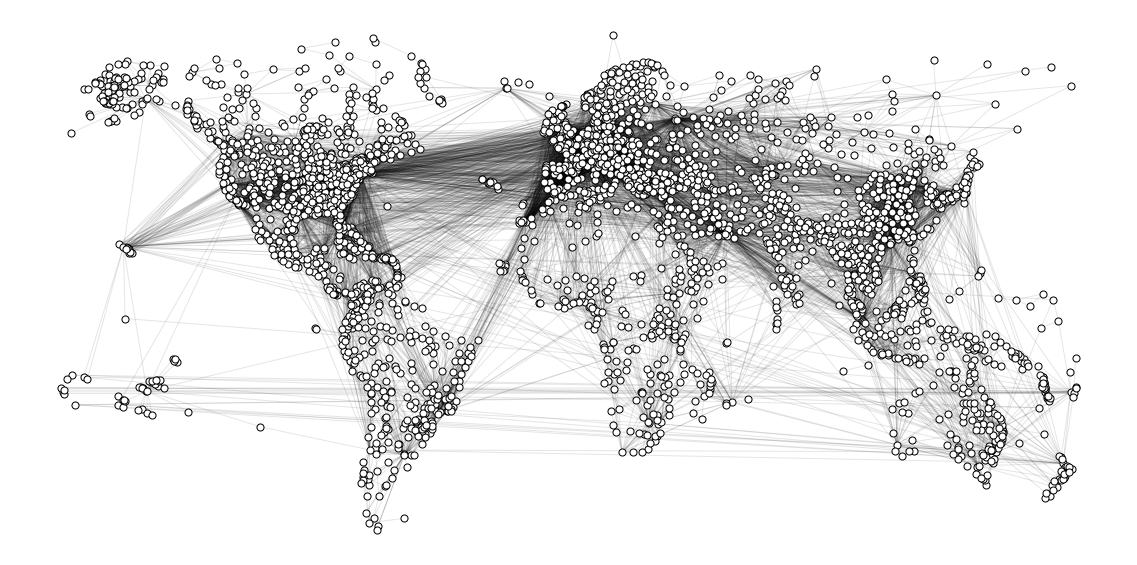

In [90]:
display_graph(graph,pos = pos,figsize = (20,10),node_size = 50)

In [31]:
# Spectral embedding
adjacency = nx.to_scipy_sparse_matrix(graph)
samples = spectral_embedding(adjacency,8)

In [32]:
# Hierarchical clustering
D = sch.linkage(samples, method =  'ward')

In [33]:
# Main airports
degree_threshold = 100
nodes = [u for u in graph.nodes() if graph.degree(u) > degree_threshold]
index = np.array([i for i,u in enumerate(graph.nodes()) if graph.degree(u) > degree_threshold])
n = len(nodes)

In [34]:
# Hierarchical clustering of the main airports 
restricted_D = sch.linkage(samples[index], method =  'ward')

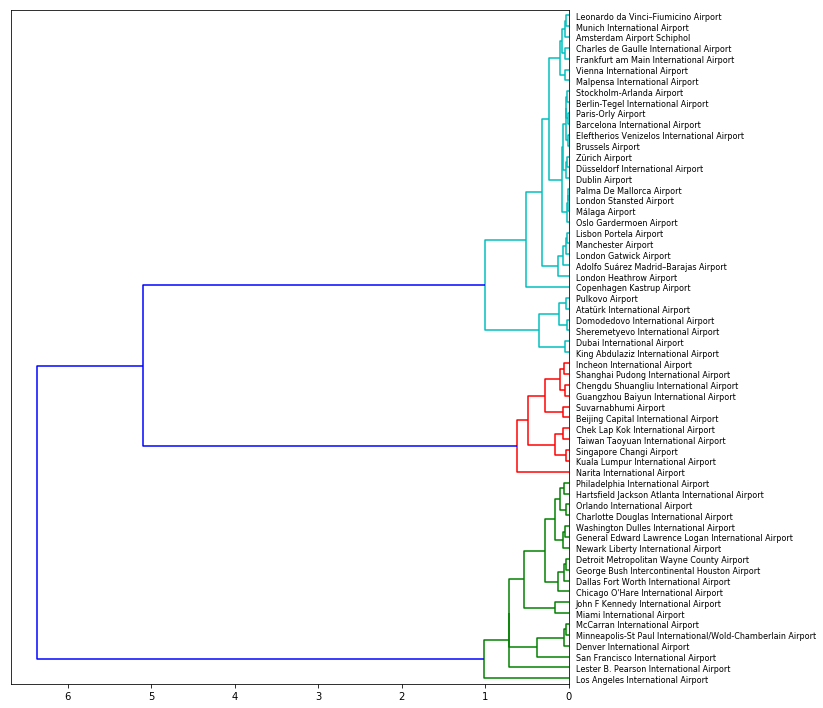

In [35]:
plt.figure(figsize = (10,n*0.2))
sch.dendrogram(restricted_D,orientation = 'left',leaf_font_size = 8,labels = [names[nodes[i]] for i in range(n)])
plt.show()

In [36]:
# Clustering
labels = select_clustering(D, 10)

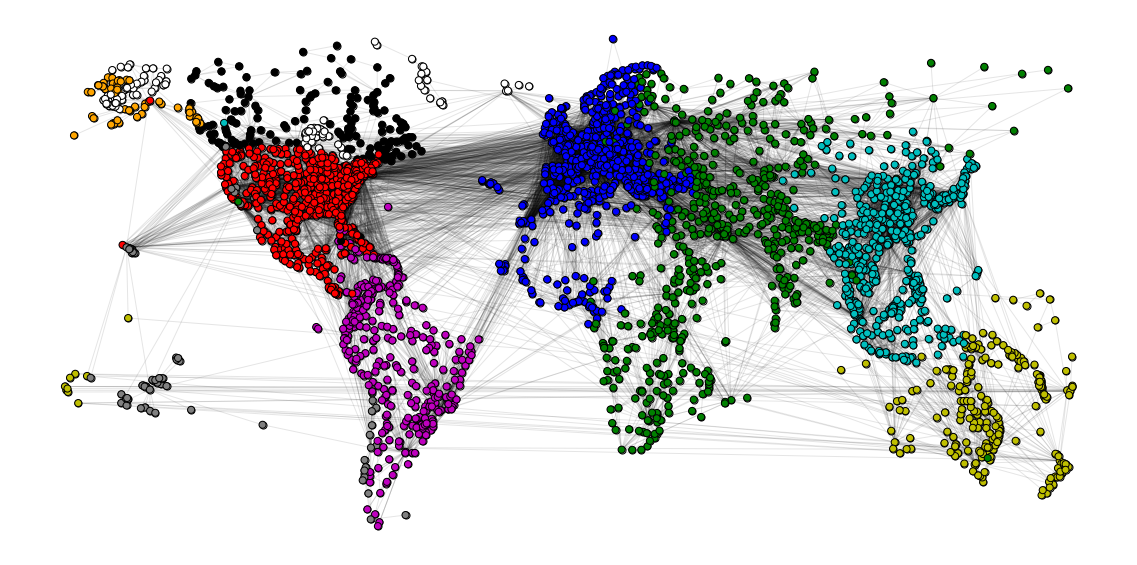

In [37]:
display_graph(graph,labels = labels, pos = pos,figsize = (20,10),node_size = 50)